In [1]:
using CSV, Downloads, NetCDF, DataFrames, IDFCurves, QuantileMatching
using Extremes, Dates, Distributions, Gadfly, Statistics, Interpolations, Compose, Optim

Mon calepin se base sur une branche contenant du code modifié: 

Je commence d'abord par modéliser la série de maxima annuels historiques par une dGEV avec copule gaussienne et corrélation materne. Je trace ensuite le QQ-plot pour la durée de 24h. J'ai fait une approche en 2 temps pour valider qu'il n'y a pas de maximum local pour la vraisemblance avant de continuer avec copule gaussience.

In [2]:
# Load observations from Montreal Trudeau weather station over 1943-2014.
idf_mtl_trudeau = CSV.read("data/702S006-2.csv", DataFrame)
idf_mtl_trudeau = idf_mtl_trudeau[idf_mtl_trudeau.Year .>= 1955, :]
first(idf_mtl_trudeau, 5)

Row,Year,5min,10min,15min,30min,1h,2h,6h,12h,24h
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1955,140.4,93.0,67.2,33.6,17.8,9.25,3.5167,2.925,1.4708
2,1956,103.2,54.6,54.0,33.6,30.5,18.65,7.0333,3.725,1.8625
3,1957,122.4,106.8,93.6,53.4,26.7,13.95,5.85,3.2417,1.725
4,1958,85.2,73.2,66.0,34.6,17.8,15.25,8.9667,5.95,3.0167
5,1959,85.2,70.2,54.8,37.6,27.7,16.25,6.1833,4.4417,2.2875


In [3]:
durations = [1/12, 1/6, 1/4, 1/2, 1, 2, 6, 12, 24]
tags = names(idf_mtl_trudeau)[2:10]
duration_dict = Dict(zip(tags, durations))
data = IDFdata(idf_mtl_trudeau, "Year", duration_dict)

IDFdata
  5min: Vector{Float64}[64]
  10min: Vector{Float64}[64]
  15min: Vector{Float64}[64]
  30min: Vector{Float64}[64]
  1h: Vector{Float64}[64]
  2h: Vector{Float64}[64]
  6h: Vector{Float64}[64]
  12h: Vector{Float64}[64]
  24h: Vector{Float64}[64]


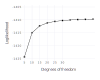

In [4]:
initialvalues = [20, 5, .04, .76, .07, 1., 2.]

df = DataFrame(ν = Int64[], loglikelihood = Float64[])

for ν in 5:5:50
    ddGEVmodel = IDFCurves.fit_mle(DependentScalingModel{GeneralScaling, MaternCorrelationStructure, TCopula{ν}},
        data, 1, initialvalues)

    ℓ = IDFCurves.loglikelihood(ddGEVmodel, data)
    
    push!(df, [ν, ℓ])
    
end

Gadfly.set_default_plot_size(10cm, 8cm)

fig = plot(df, x=:ν, y=:loglikelihood, Geom.point, Geom.line, 
    Theme(default_color="black", lowlight_color=c->"lightgray"),
    Guide.xticks(ticks=5:5:30), Guide.xlabel("Degrees of freedom"),
    Guide.ylabel("Loglikelihood"))

DependentScalingModel{GeneralScaling{Float64}, MaternCorrelationStructure{Float64}, GaussianCopula}(GeneralScaling{Float64}(d₀ = 1.0, μ₀ = 20.4906, σ₀ = 5.8795, ξ = -0.0353, α = 0.7791, δ = 0.0885)
, MaternCorrelationStructure{Float64}(1.0492610141267718, 2.1842525661970917))


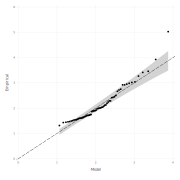

In [5]:
initialvalues = [20, 5, .04, .76, .07, 1., 2.]

pd = DependentScalingModel{GeneralScaling, MaternCorrelationStructure, GaussianCopula}
gaussian_fd = IDFCurves.fit_mle(pd, data, 1, initialvalues)

set_default_plot_size(18cm, 18cm)

println(gaussian_fd)
p1_24h = IDFCurves.qqplotci(gaussian_fd, data, 24)

Ensuite, je conserve l'estimation du paramètre delta pour réutiliser celle-ci plus tard avec les données simulées. Je trace les courbes IDF en prenant soin de calculer les intervalles de confiance en utilisant les distributions marginales produites par la dGEV.

Il semble y avoir du chauvachement entre les intervalles de confiance pour les niveaux de retour 50 et 100 ans, alors que je me serais attendu au contraire.

In [6]:
delta = offset(getmarginalmodel(gaussian_fd))

0.08852756962813187

┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ shape
└ @ Gadfly C:\Users\CM\.julia\packages\Gadfly\OQ068\src\Gadfly.jl:503
┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ shape
└ @ Gadfly C:\Users\CM\.julia\packages\Gadfly\OQ068\src\Gadfly.jl:503


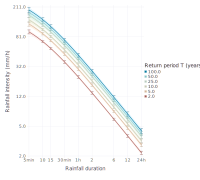

In [7]:
set_default_plot_size(20cm, 18cm)
plotIDFCurves(gaussian_fd, data, show_confidence_intervals=true, ribbon=true, dgev_return_levels=true)

Maintenant, je fais la même analyse en utilisant les données simulées. Je commence par construire les différentes séries de maxima annuels pour les 50 ensembles climex. J'analyse par la suite seulement le premier ensemble, soit kda.

J'applique une méthode de correction de biais paramétrique basée sur XCDF-t. Je conserve ensuite seulement les années qui correspondent au même intervalle que les données historiques (1955-2021)

In [11]:
# CLIMEX, composé de 50 membres, mais spécifiquemenet au point latitude, longitude Montreal.
"""
    annualmax(durations::Vector{<:Real}, all::Bool = true, writeOut::Bool = false)

    Annual maximum of array data.
    Hourly time series. Extract the highest value for year i.
"""
function annualmax(durations::Vector{<:Real}, all::Bool = true, writeOut::Bool = false)
    folder_path = "data/climEx_hrs"
    csv_dict = Dict{String, DataFrame}()
    csv_files = filter(x -> occursin(".csv", x), readdir(folder_path))

    for file in csv_files
        # Initialize an empty DataFrame for storing results
        final_df = DataFrame()

        for duration in durations
            file_path = joinpath(folder_path, file)
            climex_df = CSV.read(file_path, DataFrame)

            df_daily_agg = combine(groupby(transform(climex_df, :Date => ByRow(x->round(x, Dates.Hour(duration), RoundDown)) => :Grouped_Period, renamecols=false),  :Grouped_Period), :Pluie=>sum=>:Pluie)
            df_daily_agg = transform(df_daily_agg, :Grouped_Period => ByRow(x -> Dates.year(x)) => :Year, copycols=false)
            numYears = unique(df_daily_agg[!,:Year])

            annual_maxima = zeros(length(numYears))
            for i in 1:(length(numYears))
                idx = searchsortedfirst(df_daily_agg[!,:Year], numYears[i]):searchsortedlast(df_daily_agg[!,:Year], numYears[i])
                annual_maxima[i] = Statistics.maximum(df_daily_agg[idx,:Pluie])
            end

            maxima_col = string("Maxima $(duration)h")
            df_annual_maxima = DataFrame(Year = numYears, Maxima = annual_maxima)
            df_annual_maxima = rename(df_annual_maxima, :Maxima => maxima_col)
            df_annual_maxima[!, maxima_col] = Float64.(df_annual_maxima[!, maxima_col]) ./ duration

            if writeOut
                CSV.write(string("$(duration)h.csv"), df_annual_maxima)
            end

            # Combine with final DataFrame
            if ncol(final_df) == 0
                final_df = df_annual_maxima
            else
                final_df = outerjoin(final_df, df_annual_maxima, on=:Year, makeunique=true)
            end
            clean_df = dropmissing(final_df)
            csv_dict[file] = clean_df

        end

        if !all
            break
        end
    end

    return csv_dict
end 

df_annual_maxima = annualmax([1,2,6,12,24], false)
df_climex = df_annual_maxima["kda.csv"]

Row,Year,Maxima 1h,Maxima 2h,Maxima 6h,Maxima 12h,Maxima 24h
,Int64,Float64,Float64,Float64,Float64,Float64
1,1955,14.214,10.1337,4.29223,2.18136,1.32693
2,1956,15.17,9.3672,4.10434,2.17989,1.75852
3,1957,64.6999,47.1591,17.1832,8.59173,4.29587
4,1958,40.7226,27.7022,9.53986,4.77297,2.43328
5,1959,21.1702,11.2942,4.24236,3.7224,2.34809
6,1960,19.8433,15.9374,7.06427,3.54471,1.90596
7,1961,26.574,17.351,5.98105,3.52962,1.76481
8,1962,30.3827,15.1914,6.78306,3.7516,2.04078
9,1963,13.5234,11.5247,5.91036,4.73592,2.36799


In [12]:
idf_mtl_trudeau_1955_2021 = idf_mtl_trudeau[idf_mtl_trudeau.Year .>= 1955, :]
df_1955_2021 = df_climex[2021 .>= df_climex.Year, :]
df_2022_2099 = df_climex[df_climex.Year .>= 2022, :]

function generate_pqm(obs_location_column, location_column)
    x_o = idf_mtl_trudeau_1955_2021[!,obs_location_column]
    x_h = df_1955_2021[!,location_column]
    x_p = df_2022_2099[!,location_column]

    x_o = filter(val -> val >0, x_o)
    x_h = filter(val -> val >0, x_h)
    x_p = filter(val -> val >0, x_p)

    fm_24h_obs = gevfit(idf_mtl_trudeau_1955_2021, obs_location_column)
    fm_24h_sim = gevfit(df_1955_2021, location_column)
    fm_24h_proj = gevfit(df_2022_2099, location_column)

    f_obs = GeneralizedExtremeValue(fm_24h_obs.θ̂[1], exp(fm_24h_obs.θ̂[2]), fm_24h_obs.θ̂[3])
    f_sim = GeneralizedExtremeValue(fm_24h_sim.θ̂[1], exp(fm_24h_sim.θ̂[2]), fm_24h_sim.θ̂[3])
    f_proj = GeneralizedExtremeValue(fm_24h_proj.θ̂[1], exp(fm_24h_proj.θ̂[2]), fm_24h_proj.θ̂[3])

    qmm = ParametricQuantileMatchingModel(f_obs, f_sim, f_sim) 
    x̃_h = match(qmm, x_h)

    qmm = ParametricQuantileMatchingModel(f_obs, f_sim, f_proj)
    x̃_p = match(qmm, x_p)

    x̃ = append!(x̃_h, x̃_p)
    pqm_column = Symbol(string(obs_location_column),"-PQM")

    df_climex[!, Symbol(pqm_column)] = x̃

    # set_default_plot_size(24cm, 18cm)
    # p = Gadfly.plot(layer(df_climex, x=:Year, y=string(location_column), Geom.line),
    #     layer(df_climex, x=:Year, y=string(pqm_column), Geom.line, Theme(default_color=colorant"red")),
    #     Coord.cartesian(xmin=1955, xmax=2099), Guide.xticks(ticks=1955:10:2100),
    #     Guide.ylabel("Rainfall Intensity (mm/h)"),
    #     Guide.xlabel("Year"),
    #     Guide.title(string("XCDF-t Bias Correction of ClimEx ", obs_location_column, " Rainfall Intensity at Montreal Airport")),
    #     Guide.manual_color_key("BC method", ["Raw", "Stationary"], ["blue", "red"]))

    # display(p)
    # draw(PNG("/Users/camarois/Documents/maitrise/JuliaExtremes/maitrise/pictures/bcind/xcdf-t_1955_2099.png", 24cm, 18cm), p)
    
    fm_24h_pqm = gevfit(df_climex, pqm_column)
end

generate_pqm (generic function with 1 method)

In [13]:
generate_pqm(Symbol("1h"), Symbol("Maxima 1h"))
generate_pqm(Symbol("2h"), Symbol("Maxima 2h"))
generate_pqm(Symbol("6h"), Symbol("Maxima 6h"))
generate_pqm(Symbol("12h"), Symbol("Maxima 12h"))
generate_pqm(Symbol("24h"), Symbol("Maxima 24h"))

df_climex

Row,Year,Maxima 1h,Maxima 2h,Maxima 6h,Maxima 12h,Maxima 24h,1h-PQM,2h-PQM,6h-PQM,12h-PQM,24h-PQM
,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1955,14.214,10.1337,4.29223,2.18136,1.32693,16.5899,11.0992,4.22503,2.49031,1.37593
2,1956,15.17,9.3672,4.10434,2.17989,1.75852,17.7246,10.3629,4.06083,2.48972,1.63946
3,1957,64.6999,47.1591,17.1832,8.59173,4.29587,53.3863,35.2528,15.5502,17.6844,5.43049
4,1958,40.7226,27.7022,9.53986,4.77297,2.43328,39.6825,24.5091,8.82254,4.47562,2.21461
5,1959,21.1702,11.2942,4.24236,3.7224,2.34809,24.1127,12.1799,4.18144,3.38899,2.12917
6,1960,19.8433,15.9374,7.06427,3.54471,1.90596,22.7945,16.156,6.65105,3.25087,1.74659
7,1961,26.574,17.351,5.98105,3.52962,1.76481,29.0507,17.2738,5.70229,3.23964,1.64384
8,1962,30.3827,15.1914,6.78306,3.7516,2.04078,32.1909,15.5502,6.40466,3.41277,1.85308
9,1963,13.5234,11.5247,5.91036,4.73592,2.36799,15.7458,12.3899,5.64041,4.42791,2.14877


In [14]:
durations = [1, 2, 6, 12, 24]
df_1955_2021 = df_climex[2021 .>= df_climex.Year, :]
tags = names(df_1955_2021)[7:end]

println(tags)
duration_dict = Dict(zip(tags, durations))
climex_data = IDFdata(df_1955_2021, "Year", duration_dict)

["1h-PQM", "2h-PQM", "6h-PQM", "12h-PQM", "24h-PQM"]


IDFdata
  1h-PQM: Vector{Float64}[67]
  2h-PQM: Vector{Float64}[67]
  6h-PQM: Vector{Float64}[67]
  12h-PQM: Vector{Float64}[67]
  24h-PQM: Vector{Float64}[67]


Le pas de temps horaire est le pas le plus granulaire disponible pour les données simulées. Je commence par modéliser la dGEV en effectuant une optimisation par contrainte sur le paramètre delta en reprenant la valeur obtenue lors de l'analyse de la dGEV historique.

Je trace ensuite le QQ-plot pour la durée 24h.

DependentScalingModel{GeneralScaling{Float64}, MaternCorrelationStructure{Float64}, GaussianCopula}(GeneralScaling{Float64}(d₀ = 1.0, μ₀ = 19.4313, σ₀ = 5.1012, ξ = 0.144, α = 0.7863, δ = 0.1983)
, MaternCorrelationStructure{Float64}(0.6332232653072473, 3.1410061503551225))


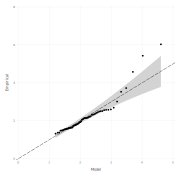

In [15]:
initialvalues = [18, 5, .04, .76, .07, 1., 2.]
constrainedvalues = [nothing, nothing, nothing, nothing, log(delta), nothing, nothing]

pd = DependentScalingModel{GeneralScaling, MaternCorrelationStructure, GaussianCopula}
gaussian_fd = IDFCurves.fit_mle(pd, climex_data, 1, initialvalues)

set_default_plot_size(18cm, 18cm)

println(gaussian_fd)
p1_24h = IDFCurves.qqplotci(gaussian_fd, climex_data, 24)

Enfin, je trace les courbes IDF pour les données simulées.

J'obtiens les valeurs de retour infra-horaires en calculant le quantile du niveau `p` pour la durée `d` infra-horaire. Les paramètres d'échelle de la dGEV permettent d'obtenir la distribution marginale pour une durée infra-horaire non-observée.

J'obtiens ensuite les intervalles de confiance par la méthode delta. Puisque cette méthode requiert de calculer la matrice hessienne à partir des données observées, je me questionne à savoir si c'est problématique ou non d'estimer les intervalles de confiance d'un niveau de retour infra-horaire alors que la matrice informative ne contient pas de données pour cette durée.

Évidemment, plus les durées infra-horaires s'éloignent de la dernière durée observée (1h), plus les intervalles deviennent grands et on perd l'information conjointe additionnelle.

┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ shape
└ @ Gadfly C:\Users\CM\.julia\packages\Gadfly\OQ068\src\Gadfly.jl:503
┌ Warning: The following aesthetics are mapped, but not used by any geometry:
│ shape
└ @ Gadfly C:\Users\CM\.julia\packages\Gadfly\OQ068\src\Gadfly.jl:503


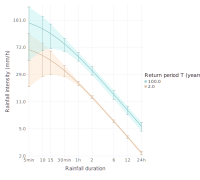

In [22]:
set_default_plot_size(20cm, 18cm)
plotIDFCurves(gaussian_fd, climex_data, show_confidence_intervals=true, ribbon=true, dgev_return_levels=true, T_values=[2,100])

Enfin, si tout cela est valide, je pensais élaborer un modèle bayésien hiérarchique pour tenir compte des 50 ensembles Climex. Le but étant d'obtenir assez d'années de données (50ensembles*66années) pour atteindre le convergence asymptotique de la méthode Delta, mais je suis sceptique quant à l'effet sur les incertitudes des données infra-horaires.

Sinon, un autre avenue serait de tenter de désaggréger/simuler des données infra-horaires qui pourront ensuite être intégrées au modèle dGEV.